In [1]:
import numpy as mp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import socket
import pickle

In [2]:
class Decision_Tree_Model_User():
    
    def __init__(self,file_link,delimiter,save_filename):
        self.data = pd.read_csv(file_link,delimiter)
        self.x = self.data[self.data.columns[0:-1]]
        self.y = self.data[self.data.columns[-1]]
        self.encoding()
        self.feature_names = self.data.columns[:-1]
        self.target_names = self.data.columns[-1]
        self.savefile = save_filename
        self.save = 0
        
    def encoding(self):
        self.y = self.y.astype('category')
        self.y = self.y.cat.codes
        
    def print_data(self):
        print (self.x)
        print (self.y)
        
    def train_test(self):
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(self.x,self.y,test_size=0.33,random_state=20)
        
    def run_model(self):
        self.train_test()
        self.dec_tree = DecisionTreeClassifier(random_state=0)
        self.dec_tree.fit(self.x,self.y)
    
    def visualize(self):
        self.run_model()
        plt.figure(figsize=(25,10))
        self.visualize = plot_tree(self.dec_tree)
        
    def save_model(self):
        self.run_model()
        pickle.dump(self.dec_tree, open(self.savefile, 'wb'))
        self.save = 1
    
    def load_model(self):
        if(self.save):
            self.dec_model = pickle.load(open(self.savefile, 'rb'))
        
        

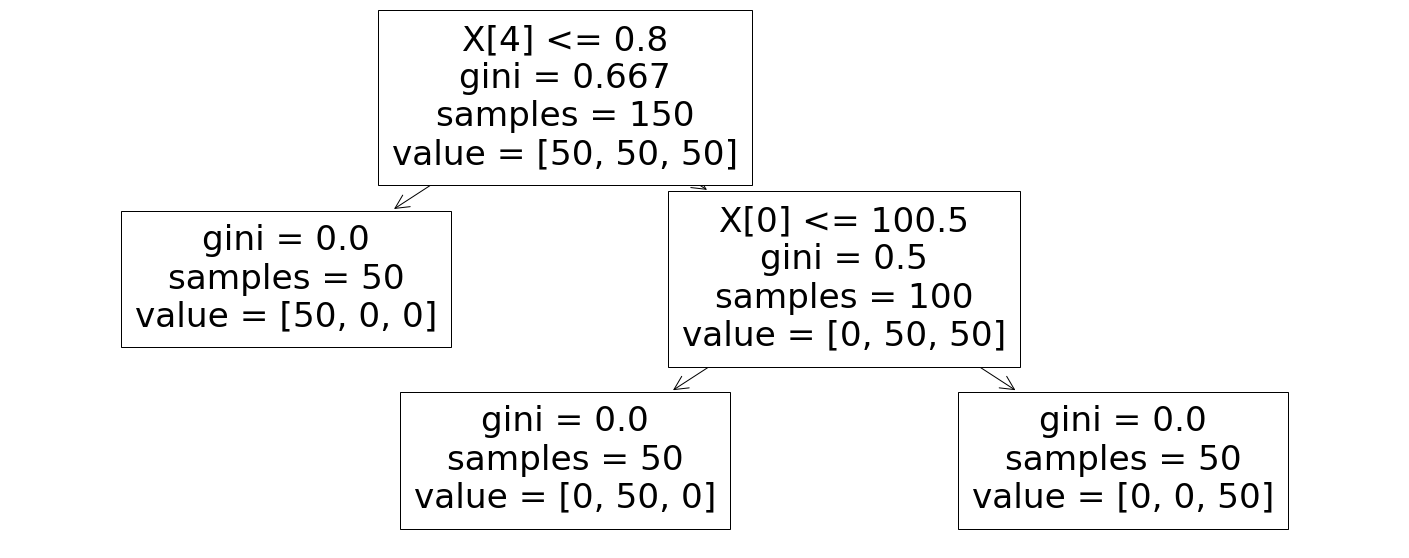

In [3]:
if __name__ == "__main__":
    r = Decision_Tree_Model_User('Iris.csv',',','Iris_data.sav')
    r.visualize()